# 1. Préparation des données

## 1.1 Import des librairies

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import plot_tree

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

## 1.2 Chargement du dataset

In [3]:
# Chargement du dataset
data = pd.read_csv('https://assets-datascientest.s3-eu-west-1.amazonaws.com/de/total/strokes.csv', sep=',', header=0)

In [4]:
# Remplacement des variables binaires
df = data.copy()
df['hypertension_v2'] = "N/A"
df.loc[df.hypertension==1, 'hypertension_v2'] = 'Yes'
df.loc[df.hypertension==0, 'hypertension_v2'] = 'No'

df['heart_disease_v2'] = 'N/A'
df.loc[df.heart_disease==1, 'heart_disease_v2'] = 'Yes'
df.loc[df.heart_disease==0, 'heart_disease_v2'] = 'No'

# df['stroke_v2'] = 'N/A'
# df.loc[df.stroke==1, 'stroke_v2'] = 'Malade'
# df.loc[df.stroke==0, 'stroke_v2'] = 'Sain'

# df = df.drop(['hypertension', 'heart_disease', 'stroke'], axis=1)
# df = df.rename(columns={"hypertension_v2": "hypertension", "heart_disease_v2": "heart_disease", "stroke_v2": "stroke", "Residence_type": "residence_type"})
df = df.drop(['hypertension', 'heart_disease'], axis=1)
df = df.rename(columns={"hypertension_v2": "hypertension", "heart_disease_v2": "heart_disease", "Residence_type": "residence_type"})

# Suppression de la colonne id
df = df.drop(['id'], axis=1)

df.head()

,gender,age,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,hypertension,heart_disease
0,Male,67.0,Yes,Private,Urban,228.69,36.6,formerly smoked,1,No,Yes
1,Female,61.0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,No,No
2,Male,80.0,Yes,Private,Rural,105.92,32.5,never smoked,1,No,Yes
3,Female,49.0,Yes,Private,Urban,171.23,34.4,smokes,1,No,No
4,Female,79.0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,Yes,No


In [5]:
# Liste des variables quantitatives et qualitatives
cols_quant = ['age', 'avg_glucose_level', 'bmi']
cols_qual = ['gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status', 'hypertension', 'heart_disease']

# 2. Exploration des données

## 2.1 Analyse de la forme

In [6]:
# Dimension du dataset
df.shape

(5110, 11)

In [7]:
# Liste des types de variables
df.dtypes.value_counts()

object     7
float64    3
int64      1
dtype: int64

<AxesSubplot:ylabel='None'>

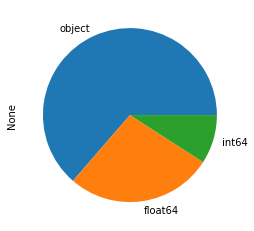

In [8]:
# Répartition des types de variables
df.dtypes.value_counts().plot.pie()

In [9]:
# Analyse des NaN
df.isna().sum()

gender                 0
age                    0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
hypertension           0
heart_disease          0
dtype: int64

<AxesSubplot:>

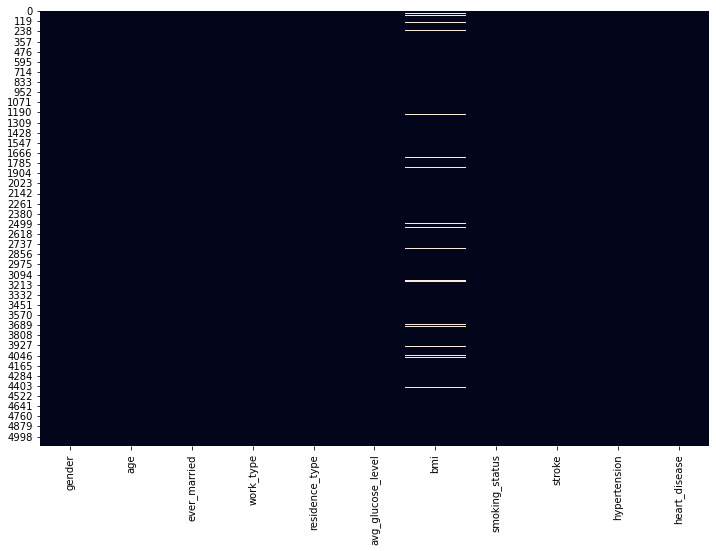

In [10]:
# Heatmap des NaN
plt.figure(figsize=(12, 8))
sns.heatmap(df.isna(), cbar=False)

* __Type__ : Classification
* __Identification de la variable target__ : Stroke
* __Shape du dataset__ : Lignes : 5110 / Colonnes : 11    
* __Types de variables__ :
    * Variables continues : age, avg_glucose_level, bmi
    * Variables discrètes : gender, ever_married, work_type, Residence_type, smoking_status, hypertension, heart_disease
* __Analyse valeurs manquantes__ :
    * Seulement des NaN pour la colonne bmi : 201 NaN
* __Elimination des colonnes inutiles__ :
    * Peu de NaN donc pas de suppression de colonnes liés au volume de NaN
    * Colonne id à supprimer

## 2.2 Analyse de fond

### 2.2.1 Analyse de la target

In [11]:
# Visualisation de la target => Classe désquilibrée
print("\n---------------")
print(df['stroke'].value_counts(normalize=True))
print("\n---------------")
print(df['stroke'].value_counts())


---------------
0    0.951272
1    0.048728
Name: stroke, dtype: float64

---------------
0    4861
1     249
Name: stroke, dtype: int64


* 5% des personnes ont déjà eu une attaque
* Classes déséquilibrés :
  * 4861 n'ont pas eu d'attaques contre 249 ui ont eu une attaque
  * Il faudra sans doute utiliser une métrique de type Score F1 ou Recall

### 2.2.2 Analyse des variables continues

In [ ]:
df.describe()

* Variables continues non standardisées
* Distribution asymétrique pour les variables avg_glucose_level et bmi

### 2.2.3 Analyse des variables discrètes

In [12]:
for col in df.select_dtypes('object'):
    print(f'{col :-<20} {df[col].unique()}')

gender-------------- ['Male' 'Female' 'Other']
ever_married-------- ['Yes' 'No']
work_type----------- ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
residence_type------ ['Urban' 'Rural']
smoking_status------ ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
hypertension-------- ['No' 'Yes']
heart_disease------- ['Yes' 'No']


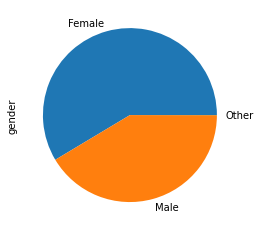

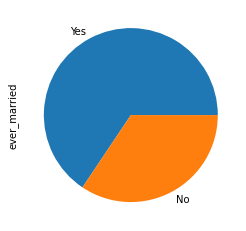

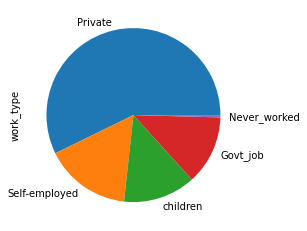

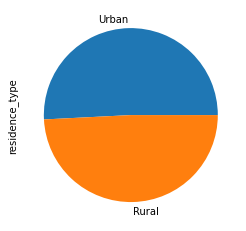

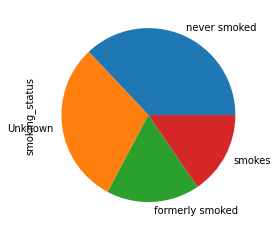

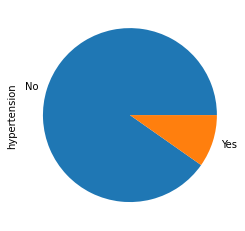

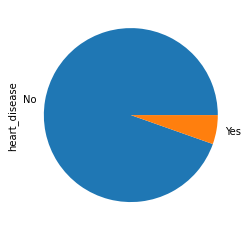

In [13]:
for col in df.select_dtypes('object'):
    plt.figure()
    df[col].value_counts().plot.pie()

* Variable __"gender"__ : Female : 2994 / Male : 2115 / Other : 1
* Variable __"ever_married"__ : Yes : 3353 / No : 1757
* Variable __"work_type"__ : Private : 2925 / Self-employed : 819 / children : 687 / Govt_job : 657 / Never_worked : 22
* Variable __"Residence_type"__ : Urban : 2596 / Rural : 2514
* Variable __"smoking_status"__ : never smoked : 1892 / Unknown : 1544 / formerly smoked : 885 / smokes : 789

### 2.2.4 Visualisation des relations variables continues et target

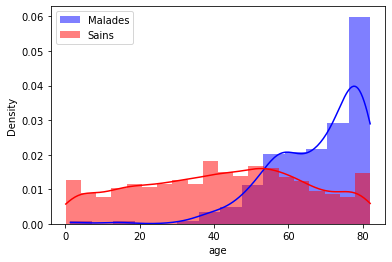

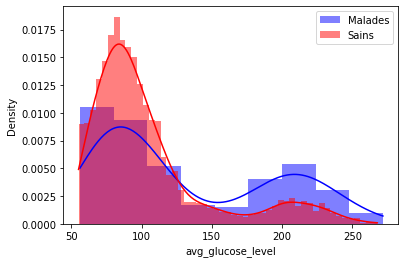

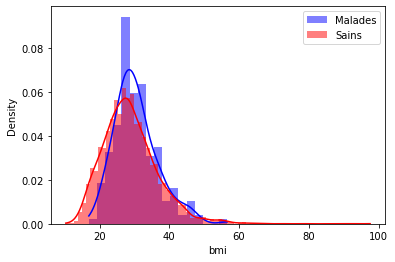

In [14]:
# Distribution
for col in cols_quant:
  sns.histplot(df.loc[df.stroke == 1][col], color="blue", label="Malades", kde=True, stat="density", linewidth=0)
  sns.histplot(df.loc[df.stroke == 0][col], color="red", label="Sains", kde=True, stat="density", linewidth=0)
  plt.legend()
  plt.show()

<AxesSubplot:>

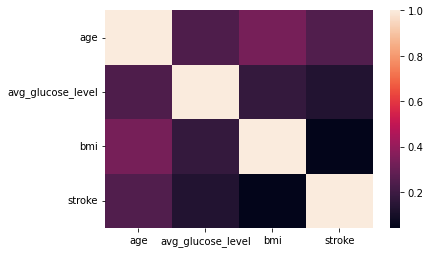

In [15]:
# Matrice de corrélation
sns.heatmap(df.corr())

* __Relation stroke-age__ : 
    * Il semble y avoir une corrélation entre risque d'attaque et âge    
* __Relation stroke-avg_glucose_level__ :
    * Il semble y avoir une faible corrélation entre risque d'attaque et le taux moyen de sucre
* __Relation stroke-bmi__ :
    * Il semble ne pas y avoir de corrélation entre risque d'attaque et IMC 

### 2.2.5 Visualisation des relations variables discrètes et target

In [16]:
pd.crosstab(df['stroke'], df['ever_married'])

ever_married,No,Yes
stroke,,
0,1728,3133
1,29,220



### gender ###



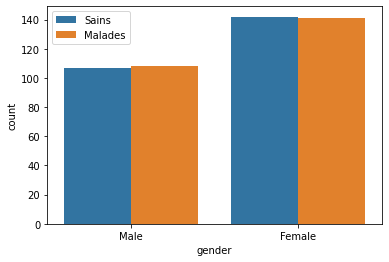


### ever_married ###



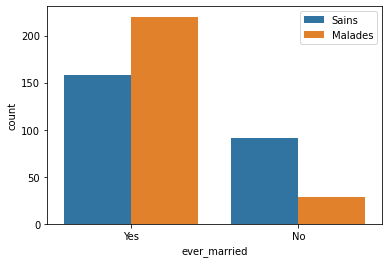


### work_type ###



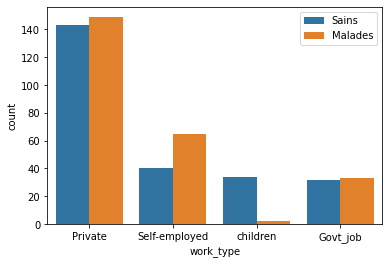


### residence_type ###



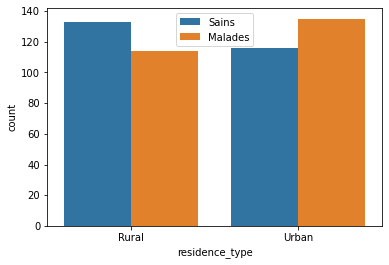


### smoking_status ###



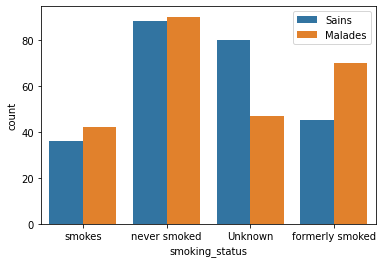


### hypertension ###



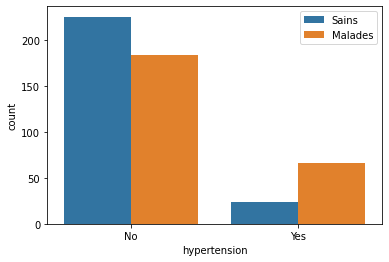


### heart_disease ###



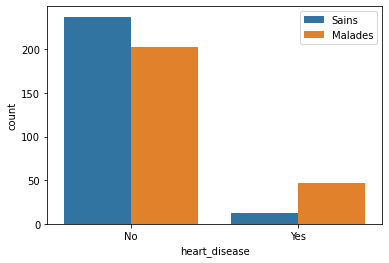

In [17]:
# On ré-équilibre les classes pour que les histogrammes soient plus parlants
df_balanced = pd.concat([df[df.stroke == 0].sample(df[df.stroke == 1].shape[0]), df[df.stroke == 1]], axis=0)

for col in cols_qual:  
  print("\n###", col, "###\n")
  sns.countplot(x=col, hue='stroke', data=df_balanced)
  plt.legend(labels=['Sains', 'Malades'])
  plt.show()

* __Relation stroke/gender__ :
    * Il ne semble pas y avoir de corrélation entre risque d'attaque et genre
* __Relation stroke/hypertension__ :
    * Il semble y avoir une corrélation entre risque d'attaque et hypertension
        * Les personnes ayant de l'hypertension ont un risque plus important d'avoir une attaque
* __Relation stroke/heart_disease__ : 
    * Il semble y avoir une corrélation entre risque d'attaque et maladies cardiaques
        * Les personnes ayant une maladie cardiaque ont un risque plus important d'avoir une attaque
* __Relation stroke/ever_married__ :
    * Il semble y avoir une corrélation entre risque d'attaque et le fait d'être marié ou non
        * Les personnes mariées ont un risque plus important d'avoir une attaque
* __Relation stroke/work_type__ :
    * Il semble y avoir une faible corrélation entre risque d'attaque et le type de travail
        * Les entrepreneurs ont un risque plus important d'avoir une attaque
* __Relation stroke/residence_type__ :
    * Pas de corrélation entre risque d'attaque et le fait d'habiter en ville ou à la campagne
* __Relation stroke/smoking_status__ :
    * Il semble y avoir une corrélation entre risque d'attaque et le statut de fumeur
        * Les anciens fumeurs ont un risque plus important d'avoir une attaque

# 3. Pre-processing

In [18]:
all_features = ['age', 'avg_glucose_level', 'bmi', 'gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status', 'hypertension', 'heart_disease']
quantitative_features = ['age', 'avg_glucose_level', 'bmi']
qualitative_features = ['gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status', 'hypertension', 'heart_disease']
target = ['stroke']

In [19]:
def loading(file):
    data = pd.read_csv(file, sep=',', header=0)
    df = data.copy()    
    df = df.rename(columns={"Residence_type": "residence_type"})    
    df = df.drop(['id'], axis=1)
    return(df)

In [20]:
def encoding(df, var_qual):
    gender_code = {'Other': 0, 'Male': 1, 'Female': 2}
    ever_married_code = {'No': 0, 'Yes': 1}
    work_type_code = {'Private': 0, 'Self-employed': 1, 'children': 2, 'Govt_job': 3, 'Never_worked': 4}
    residence_type_code = {'Urban': 0, 'Rural': 1}
    smoking_status_code = {'never smoked': 0, 'Unknown': 1, 'formerly smoked': 2, 'smokes': 3}
    
    df.loc[:, 'gender'] = df['gender'].map(gender_code)        
    df.loc[:, 'ever_married'] = df['ever_married'].map(ever_married_code)        
    df.loc[:, 'work_type'] = df['work_type'].map(work_type_code)        
    df.loc[:, 'residence_type'] = df['residence_type'].map(residence_type_code)        
    df.loc[:, 'smoking_status'] = df['smoking_status'].map(smoking_status_code)    
    return df.loc[:, var_qual]

In [21]:
def scaling(df, var_quant):
    scaler = RobustScaler()    
    return pd.DataFrame(data=scaler.fit_transform(df[quantitative_features]), 
                        columns=quantitative_features)

In [22]:
def imputation(df):    
    # df = df.dropna(axis=0)
    # df.drop(['gender', 'ever_married', 'work_type', 'residence_type', 'hypertension', 'heart_disease'], axis=1, inplace=True)
    df.bmi.fillna(df.bmi.mean(), inplace=True)    
    return df

In [23]:
# On définit une pipeline de preprocessing
def preprocessing(var_quant, var_qual, var_target, sampling=False):        
    # df = loading('data/strokes.csv')
    df = loading('https://assets-datascientest.s3-eu-west-1.amazonaws.com/de/total/strokes.csv')    
    # df = imputation(df)
    df_quant = scaling(df, var_quant)
    df_qual = encoding(df, var_qual)
    
    X = pd.concat([df_quant, df_qual], axis=1)
    y = df.loc[:, 'stroke']            
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Sur-échantillonnage Target
    # Cela est fait seulement sur la partie train du dataset, effectivement, effectuer un resampling sur les données de test fausse les résultats
    # Cloner les samples avant découpe train / test, va inévitablement provoquer la présence de samples du test dans le train et donc un leak
    if sampling:        
        rOs = RandomOverSampler()
        X_train, y_train = rOs.fit_resample(X_train, y_train)
            
    return X_train, X_test, y_train, y_test

In [24]:
X_train, X_test, y_train, y_test = preprocessing(quantitative_features, qualitative_features, target, False)

In [25]:
print("\n--------------")
print("X_train :", X_train.shape, "/ y_train :", y_train.shape)

print("\n--------------")
print("\nX_test :", X_test.shape, "/ y_test :", y_test.shape)

print("\n--------------")
print("y_train :")
print(y_train.value_counts())

print("\n--------------")
print("y_test :")
print(y_test.value_counts())


--------------
X_train : (4088, 10) / y_train : (4088,)

--------------

X_test : (1022, 10) / y_test : (1022,)

--------------
y_train :
0    3893
1     195
Name: stroke, dtype: int64

--------------
y_test :
0    968
1     54
Name: stroke, dtype: int64


# 4. Modélisation

## 4.1 Evaluation sans rééquilabrage de la target

### 4.1.1 Définition des méthodes d'évaluation

In [30]:
# Evaluation du modèle
def evaluation(model, X_train, y_train, X_test, y_test):
    print(X_train.head())
    print(y_train.head())
    print(X_test.head())
    print(y_test.head())
        
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("\n---------------------------------")
    print("Confusion matrix :")
    print(confusion_matrix(y_test, y_pred))
    
    print("\n---------------------------------")
    print("Classification report :")
    print(classification_report(y_test, y_pred))
    
    N, train_score, val_score = learning_curve(
        model, X_train, y_train, cv=5, scoring='f1',
        train_sizes=np.linspace(0.1, 1, 10))
    
    plt.figure(figsize=(15, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    plt.show()  

In [31]:
# Optimisation des paramètres
def best_params(model, X_train, y_train):
    params = {'selectkbest__k': range(1, 11)}
    grid = GridSearchCV(model, params, scoring='f1', cv=5)
    grid.fit(X_train, y_train)
    print("\n", grid.best_params_)

### 4.1.2 Choix du modèle de classification

In [32]:
# On a fait le choix de sélectionner 3 modèles qui nous semblent les plus
# adaptés
def best_classifier(X_train, y_train, X_test, y_test, strategy):
    logistic_regression = \
        make_pipeline(SimpleImputer(missing_values=np.nan, strategy=strategy),
                                    SelectKBest(f_classif, k=10),
                                    LogisticRegression(random_state=0))
    
    decision_tree = \
        make_pipeline(SimpleImputer(missing_values=np.nan, strategy=strategy),
                      SelectKBest(f_classif, k=10),
                      DecisionTreeClassifier(random_state=0))
    
    knn = \
        make_pipeline(SimpleImputer(missing_values=np.nan, strategy=strategy),
                      SelectKBest(f_classif, k=10),
                      KNeighborsClassifier(n_neighbors=5))

    dict_models = {'LogisticRegression': logistic_regression,
                   'DecisionTree' : decision_tree,
                   'KNeighbors': knn}

    for name, model in dict_models.items():
        print("\n############################################################")
        print("Modèle :", name)
        
        # Evaluation du modèle
        evaluation(model, X_train, y_train, X_test, y_test)
        
        # Optimisation des paramètres
        best_params(model, X_train, y_train)


############################################################
Modèle : LogisticRegression
           age  avg_glucose_level       bmi  gender  ever_married  work_type  \
3029 -0.250000          -0.667526  0.895833       2             1          0   
2277 -0.305556          -0.226761  2.125000       2             1          0   
3002  0.416667          -0.725336  0.281250       1             1          0   
246   0.833333          -0.355136  0.125000       2             1          1   
2825  0.861111          -0.902022 -0.260417       1             1          0   

      residence_type  smoking_status  hypertension  heart_disease  
3029               1               2             0              0  
2277               1               2             0              0  
3002               1               0             0              0  
246                1               2             0              0  
2825               0               3             0              0  
3029    0
2277    0
3

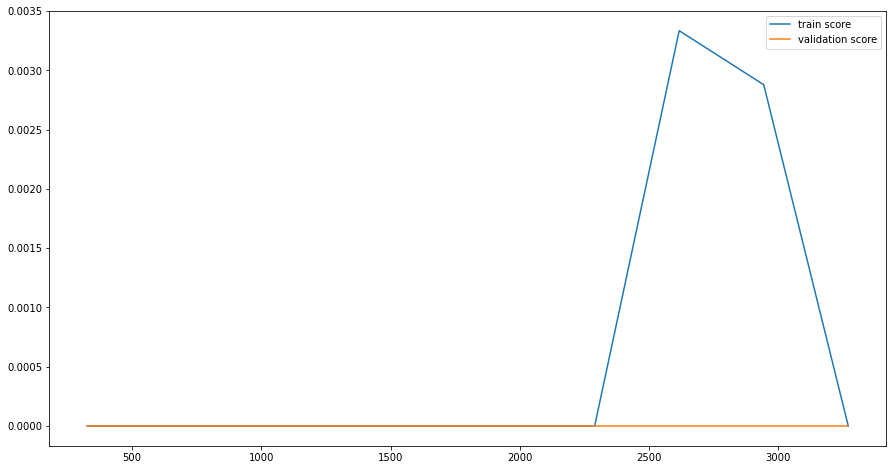


 {'selectkbest__k': 1}

############################################################
Modèle : DecisionTree
           age  avg_glucose_level       bmi  gender  ever_married  work_type  \
3029 -0.250000          -0.667526  0.895833       2             1          0   
2277 -0.305556          -0.226761  2.125000       2             1          0   
3002  0.416667          -0.725336  0.281250       1             1          0   
246   0.833333          -0.355136  0.125000       2             1          1   
2825  0.861111          -0.902022 -0.260417       1             1          0   

      residence_type  smoking_status  hypertension  heart_disease  
3029               1               2             0              0  
2277               1               2             0              0  
3002               1               0             0              0  
246                1               2             0              0  
2825               0               3             0              0  
302

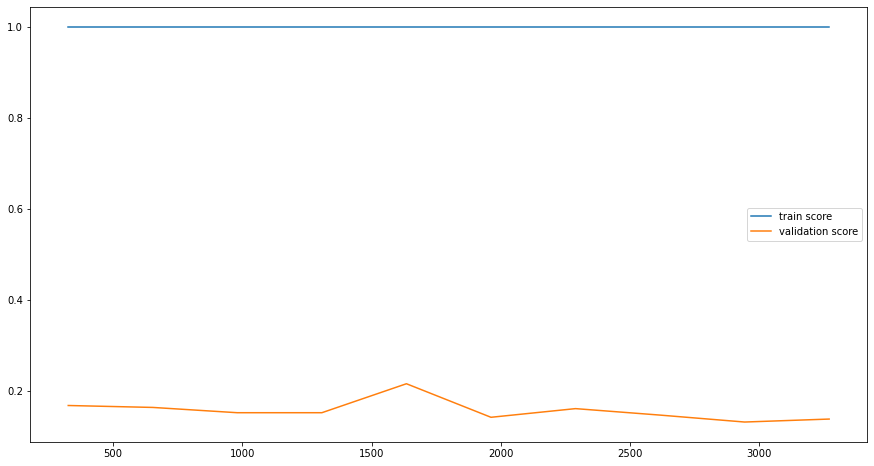


 {'selectkbest__k': 10}

############################################################
Modèle : KNeighbors
           age  avg_glucose_level       bmi  gender  ever_married  work_type  \
3029 -0.250000          -0.667526  0.895833       2             1          0   
2277 -0.305556          -0.226761  2.125000       2             1          0   
3002  0.416667          -0.725336  0.281250       1             1          0   
246   0.833333          -0.355136  0.125000       2             1          1   
2825  0.861111          -0.902022 -0.260417       1             1          0   

      residence_type  smoking_status  hypertension  heart_disease  
3029               1               2             0              0  
2277               1               2             0              0  
3002               1               0             0              0  
246                1               2             0              0  
2825               0               3             0              0  
3029

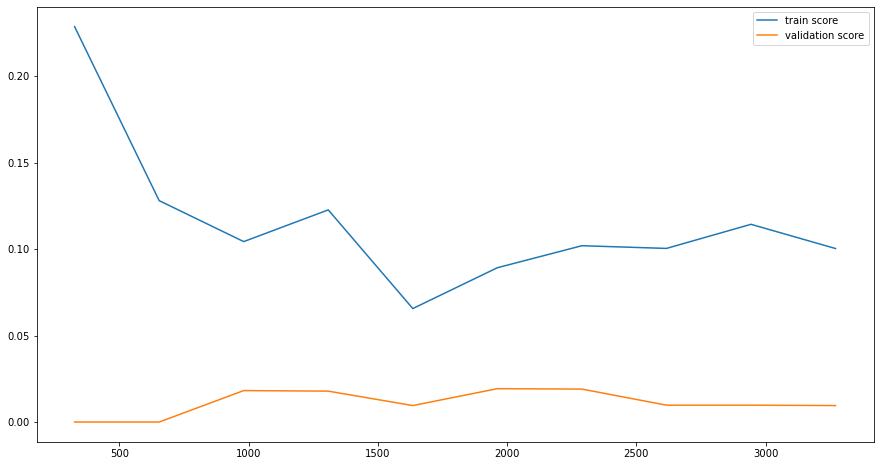


 {'selectkbest__k': 5}


In [33]:
best_classifier(X_train, y_train, X_test, y_test, 'mean')

__Au vu des paramètres de précision, recall et f1-score, le modèle le plus adapté est le DecisionTreeClassifier__

Plusieurs itérations ont été effectués pour déterminer la meilleur stratégie pour le remplacement de NaN :
* Itération initiale
    * Imputer strategy : mean
    * Training score : environ 100% => Modèle en overfitting
    * Validation score : environ 15%    
* Nouvelle itération
    * Imputer strategy : median
    * Training score : environ 100% => Modèle en overfitting
    * Validation score : environ 8%
* Nouvelle itération
    * Imputer strategy : most_frequent
    * Training score : environ 100% => Modèle en overfitting
    * Validation score : environ 14%

* __Choix final__
    * Modèle de classification : DecisionTreeClassifier
    * Simple imputer strategy : mean
    * SelectKBest : k = 10

### 4.1.3 Evaluation du modèle sélectionné avec les meilleurs paramètres

In [ ]:
model = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'),
                      SelectKBest(f_classif, k=10),
                      DecisionTreeClassifier(random_state=0))

evaluation(model, X_train, y_train, X_test, y_test)

__Conlusions__ :

Pour les prédictions sur les risques d'attaque cardiaque :
  * __F1 score__ : 15%
  * __Recall__ : 15%
    
Score assez faible qui s'explique en parti avec une target déséquilibrée.<br>
Une nouvelle évaluation pourrait être réalisée avec un rééquibrage de la target

### 4.1.4 Visualisation des features les plus importantes

In [ ]:
def most_important_features(features):
    features = model.steps[1][1].get_feature_names_out(all_features)
    features_importances = model.steps[2][1].feature_importances_
    print(pd.DataFrame(features_importances, index=features))
    print("\n")
    pd.DataFrame(features_importances, index=features).plot.bar(figsize=(20, 8))

In [ ]:
most_important_features(all_features)

__Features les plus importantes (dans l'ordre)__ :
* Taux de glucose moyen
* IMC
* âge

### 4.1.5 Visualisation de l'arbre

In [ ]:
plt.figure(figsize=(15,12))
plot_tree(model.steps[2][1], feature_names = all_features, filled=True);

Le modèle n'est pas du tout interprétable, il y a trop de branches.

## 4.2 Evaluation avec rééquilibrage de la target

In [ ]:
# Pré-processing avec rééquilibrage de la target
X_train, X_test, y_train, y_test = preprocessing(quantitative_features, qualitative_features, target, sampling=True)

In [ ]:
print("\n--------------")
print("X_train :", X_train.shape, "/ y_train :", y_train.shape)

print("\n--------------")
print("\nX_test :", X_test.shape, "/ y_test :", y_test.shape)

print("\n--------------")
print("y_train :")
print(y_train.value_counts())

print("\n--------------")
print("y_test :")
print(y_test.value_counts())

In [ ]:
# Choix du modèle de classification
best_classifier(X_train, y_train, X_test, y_test, 'mean')

__Au vu des paramètres de précision, recall et f1-score, il est difficile de séléectionner un modèle :__
* D'un point de vue des personnes saines, le Decision Tree est le modèle le plus adaptée
* D'un point de vue des personnes malades, la Régression Logistic est le modèle le plus adaptée

La stratégie du rééquilibrage de la target n'a pas forcément apporté une meilleure évaluation.



In [ ]:
# Evaluation finale avec Decision Tree
model = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'),
                      SelectKBest(f_classif, k=8),
                      DecisionTreeClassifier(random_state=0))

evaluation(model, X_train, y_train, X_test, y_test)

In [ ]:
most_important_features(all_features)

# Dans l'ordre d'importance : Age, Taux de glucose moyen et IMC

__Features les plus importantes (dans l'ordre)__ :
* Age
* Taux de glucose moyen
* IMC

In [ ]:
plt.figure(figsize=(15,12))
plot_tree(model.steps[2][1], feature_names = all_features, filled=True);